In [1]:
from data_tidy import read_a_season,read_all_game

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
read_a_season("../nhl_data/",2016).to_csv('./tidy_{season}.csv'.format(season=2016), sep=',',index=False)

100%|█████████████████████████████████████████████████████████████████████████████| 6433/6433 [00:25<00:00, 252.52it/s]


In [4]:
result = pd.DataFrame()
for i in [2018,2019,2020]:
    temp = read_a_season("../nhl_data/",i)
    result = pd.concat([result,temp],ignore_index=True)
result.to_csv('./tidy_{season}.csv'.format(season="2018-2020"), sep=',',index=False)

100%|█████████████████████████████████████████████████████████████████████████████| 6433/6433 [00:16<00:00, 401.38it/s]


In [5]:
season_2016_path = "./tidy_2016.csv"
season_20182020_path = "./tidy_2018-2020.csv"

In [6]:
df_2016 = pd.read_csv(season_2016_path).reset_index()
df_2016.head(10)

,index,game_id,event_idx,play_type,shot_type,shot_dist,game_time,goals_home,goals_away,attack_team_name,period,period_time_rem,coordinate,shooter_name,goalie_name,empty_Net,strength
0,0,2016020001,9,Shot,Wrist Shot,13.000000,2016-10-12T23:00:00Z,0,0,Toronto Maple Leafs,1,18:49,"{'x': -77.0, 'y': 5.0}",Mitchell Marner,Craig Anderson,NaN,NaN
1,1,2016020001,16,Shot,Wrist Shot,13.341664,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,17:07,"{'x': 86.0, 'y': 13.0}",Chris Kelly,Frederik Andersen,NaN,NaN
2,2,2016020001,23,Shot,Wrist Shot,76.157731,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,15:59,"{'x': 23.0, 'y': -38.0}",Cody Ceci,Frederik Andersen,NaN,NaN
3,3,2016020001,25,Shot,Slap Shot,57.974132,2016-10-12T23:00:00Z,0,0,Ottawa Senators,1,15:14,"{'x': 33.0, 'y': -15.0}",Erik Karlsson,Frederik Andersen,NaN,NaN
4,4,2016020001,38,Shot,Wrist Shot,61.717096,2016-10-12T23:00:00Z,0,0,Toronto Maple Leafs,1,13:14,"{'x': -34.0, 'y': 28.0}",Martin Marincin,Craig Anderson,NaN,NaN
5,5,2016020001,40,Shot,Wrist Shot,58.523500,2016-10-12T23:00:00Z,0,0,Toronto Maple Leafs,1,12:30,"{'x': -33.0, 'y': -17.0}",Mitchell Marner,Craig Anderson,NaN,NaN
6,6,2016020001,43,Goal,Wrist Shot,19.026298,2016-10-12T23:00:00Z,0,1,Toronto Maple Leafs,1,11:39,"{'x': -70.0, 'y': 1.0}",Auston Matthews,Craig Anderson,False,EVEN
7,7,2016020001,45,Shot,Wrist Shot,56.850682,2016-10-12T23:00:00Z,0,1,Toronto Maple Leafs,1,11:31,"{'x': -45.0, 'y': -36.0}",Matt Martin,Craig Anderson,NaN,NaN
8,8,2016020001,48,Shot,Slap Shot,58.821765,2016-10-12T23:00:00Z,0,1,Ottawa Senators,1,11:00,"{'x': 33.0, 'y': -18.0}",Erik Karlsson,Frederik Andersen,NaN,NaN
9,9,2016020001,59,Shot,Wrist Shot,58.523500,2016-10-12T23:00:00Z,0,1,Ottawa Senators,1,09:44,"{'x': 34.0, 'y': 20.0}",Erik Karlsson,Frederik Andersen,NaN,NaN


In [7]:
df_2016_shots = df_2016.groupby(["attack_team_name","shot_type"]).agg("count").reset_index()
df_2016_shots = df_2016_shots.pivot(columns = "attack_team_name",index = "shot_type", values = "index")
df_2016_total = pd.DataFrame(df_2016_shots.sum(axis=1),columns = ["total_shot"])
df_2016_total

,total_shot
shot_type,
Backhand,6560
Deflected,1005
Slap Shot,13520
Snap Shot,12733
Tip-In,3980
Wrap-around,843
Wrist Shot,41737


In [8]:
df_2016_goals = df_2016[df_2016["play_type"]=="Goal"]
df_2016_goals = df_2016_goals.groupby(["attack_team_name","shot_type"]).agg("count").reset_index()
df_2016_goals = df_2016_goals.pivot(columns = "attack_team_name",index = "shot_type", values = "index")
df_2016_goals_total = pd.DataFrame(df_2016_goals.sum(axis=1),columns = ["total_goal"]).astype(int)
df_2016_goals_total

,total_goal
shot_type,
Backhand,698
Deflected,199
Slap Shot,829
Snap Shot,1172
Tip-In,713
Wrap-around,70
Wrist Shot,3681


In [109]:
df_pt1 = pd.concat([df_2016_goals_total,df_2016_total],axis = 1)
df_pt1["percentage"] = df_pt1["total_goal"]/df_pt1["total_shot"]*100
df_pt1["percentage"] = df_pt1["percentage"].round(1)
df_pt1

,total_goal,total_shot,percentage
shot_type,,,
Backhand,698,6560,10.6
Deflected,199,1005,19.8
Slap Shot,829,13520,6.1
Snap Shot,1172,12733,9.2
Tip-In,713,3980,17.9
Wrap-around,70,843,8.3
Wrist Shot,3681,41737,8.8


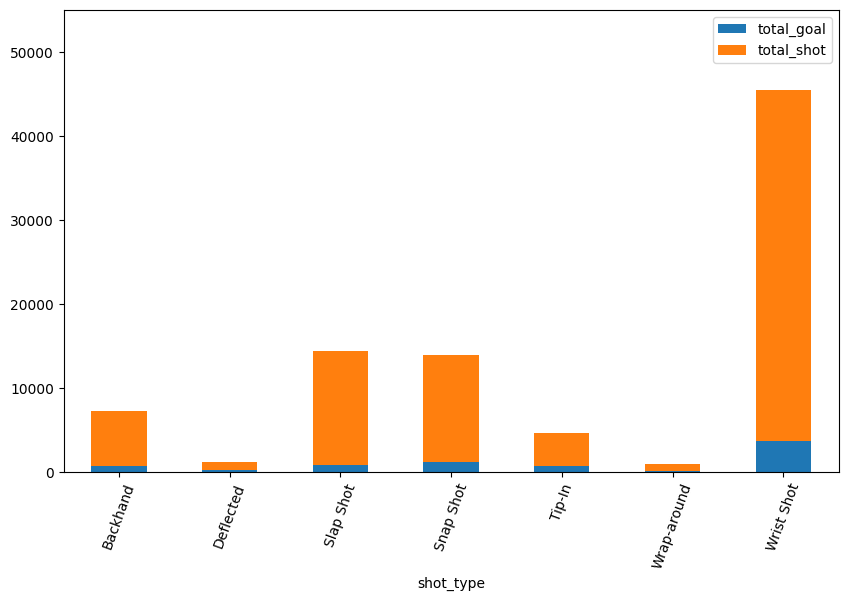

In [172]:
ax = df_pt1[["total_goal","total_shot"]].plot.bar(stacked=True,rot=70,figsize=(10, 6))
ax.set_ylim(0,55000)
plt.show()

In [11]:
df_1820 = pd.read_csv(season_20182020_path).reset_index()
df_1820.head(10)
# df_1820[df_1820["shot_dist"]>185]

,index,game_id,event_idx,play_type,shot_type,shot_dist,game_time,goals_home,goals_away,attack_team_name,period,period_time_rem,coordinate,shooter_name,goalie_name,empty_Net,strength
0,0,2018020001,4,Shot,Backhand,21.954498,2018-10-03T23:00:00Z,0,0,Montréal Canadiens,1,19:31,"{'x': 78.0, 'y': -19.0}",Artturi Lehkonen,Frederik Andersen,NaN,NaN
1,1,2018020001,5,Shot,Snap Shot,52.952809,2018-10-03T23:00:00Z,0,0,Toronto Maple Leafs,1,19:11,"{'x': -37.0, 'y': -10.0}",Morgan Rielly,Carey Price,NaN,NaN
2,2,2018020001,6,Shot,Wrist Shot,47.885280,2018-10-03T23:00:00Z,0,0,Montréal Canadiens,1,19:00,"{'x': 47.0, 'y': -23.0}",Brendan Gallagher,Frederik Andersen,NaN,NaN
3,3,2018020001,16,Shot,Snap Shot,38.626416,2018-10-03T23:00:00Z,0,0,Montréal Canadiens,1,16:06,"{'x': 53.0, 'y': 14.0}",Brendan Gallagher,Frederik Andersen,NaN,NaN
4,4,2018020001,19,Shot,Snap Shot,12.165525,2018-10-03T23:00:00Z,0,0,Montréal Canadiens,1,15:54,"{'x': 77.0, 'y': -2.0}",Mike Reilly,Frederik Andersen,NaN,NaN
5,5,2018020001,20,Shot,Backhand,9.055385,2018-10-03T23:00:00Z,0,0,Montréal Canadiens,1,15:54,"{'x': 80.0, 'y': 1.0}",Phillip Danault,Frederik Andersen,NaN,NaN
6,6,2018020001,30,Shot,Snap Shot,20.518285,2018-10-03T23:00:00Z,0,0,Montréal Canadiens,1,13:46,"{'x': 74.0, 'y': 14.0}",Max Domi,Frederik Andersen,NaN,NaN
7,7,2018020001,43,Goal,Wrap-around,3.605551,2018-10-03T23:00:00Z,0,1,Montréal Canadiens,1,10:26,"{'x': 87.0, 'y': -3.0}",Artturi Lehkonen,Frederik Andersen,False,EVEN
8,8,2018020001,47,Shot,Slap Shot,42.047592,2018-10-03T23:00:00Z,0,1,Toronto Maple Leafs,1,10:08,"{'x': -51.0, 'y': 18.0}",Zach Hyman,Carey Price,NaN,NaN
9,9,2018020001,50,Shot,Tip-In,13.892444,2018-10-03T23:00:00Z,0,1,Toronto Maple Leafs,1,09:55,"{'x': -77.0, 'y': -7.0}",Zach Hyman,Carey Price,NaN,NaN


In [12]:
df_1820_dist = df_1820[["shot_dist","play_type"]]
idx = ~pd.isna(df_1820_dist["shot_dist"])
df_1820_filtered = df_1820_dist.loc[idx].sort_values('shot_dist')
df_1820_filtered

,shot_dist,play_type
193398,1.000000,Shot
77716,1.000000,Goal
162307,1.000000,Goal
21992,1.000000,Goal
181253,1.414214,Goal
...,...,...
153778,188.023935,Goal
175199,188.023935,Shot
10745,188.382589,Shot
66749,188.409129,Shot


<Axes: xlabel='shot_dist'>

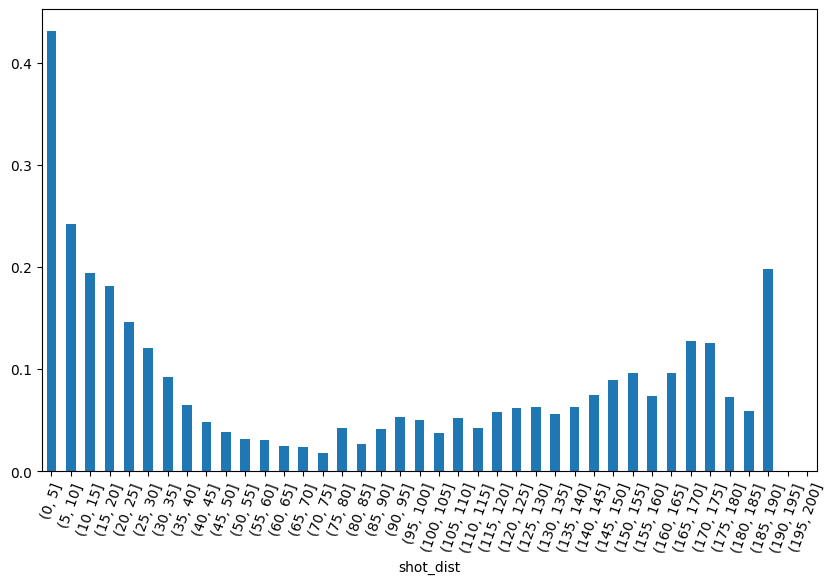

In [177]:
df_dist = df_1820_filtered[["play_type","shot_dist"]]
max_dist = np.sqrt((100*2)**2+42.5**2)
bins=list(range(0,round(max_dist),5))
df_1820_filtered_shot = df_1820_filtered[df_1820_filtered["play_type"]=="Shot"]
df_1820_filtered_goal = df_1820_filtered[df_1820_filtered["play_type"]=="Goal"]
shot_count=pd.DataFrame(pd.cut(df_1820_filtered_shot["shot_dist"],bins=bins)).reset_index()
shot_count= shot_count.groupby("shot_dist").agg("count")
shot_count = shot_count.rename(columns={'index': 'Shots'})

goal_count=pd.DataFrame(pd.cut(df_1820_filtered_goal["shot_dist"],bins=bins)).reset_index()
goal_count= goal_count.groupby("shot_dist").agg("count")
goal_count = goal_count.rename(columns={'index': 'Goals'})

shot_goal_1820 = pd.concat([shot_count,goal_count],axis=1)
shot_goal_1820["Percentage"] = shot_goal_1820["Goals"]/shot_goal_1820["Shots"]
shot_goal_1820["Percentage"].plot.bar(rot=70,figsize=(10, 6))
